In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
!wget https://github.com/shenasa-ai/iranian-car-license-plate/raw/main/iclp-part1.zip
!unzip -qq iclp-part1.zip

--2023-11-01 12:00:56--  https://github.com/shenasa-ai/iranian-car-license-plate/raw/main/iclp-part1.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shenasa-ai/iranian-car-license-plate/main/iclp-part1.zip [following]
--2023-11-01 12:00:56--  https://raw.githubusercontent.com/shenasa-ai/iranian-car-license-plate/main/iclp-part1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21385713 (20M) [application/zip]
Saving to: ‘iclp-part1.zip’

iclp-part1.zip      100%[===================>]  20.39M  --.-KB/s    in 0.09s   

2023-11-01 12:00:58 (225 MB/s) - ‘iclp-part1.zip’ saved [21385713/213

In [3]:
!ls /content/iclp-part1 | wc -l

3000


In [62]:
# Path to the data directory
data_dir = Path("./iclp-part1/")

# Get list of all the images and labels
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0].split("_")[0] for img in images]
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))

Number of images found:  3000
Number of labels found:  3000


In [63]:
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of unique characters:  26
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'H', 'J', 'K', 'L', 'M', 'N', 'S', 'T', 'V', 'X', 'Y', 'Z']


In [66]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 256
img_height = 65

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# hom many digits and char the plates have
plate_length = len(labels[0])

## Preprocessing

In [67]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [68]:
print(char_to_num.get_vocabulary())

['[UNK]', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'H', 'J', 'K', 'L', 'M', 'N', 'S', 'T', 'V', 'X', 'Y', 'Z']


In [69]:
char_to_num('A').numpy()

11

In [70]:
num_to_char(11).numpy()

b'A'

In [71]:
train_size=0.9
images, labels = np.array(images), np.array(labels)

# 1. Get the total size of the dataset
size = len(images)
# 2. Make an indices array and shuffle it, if required
indices = np.arange(size)
np.random.shuffle(indices)
# 3. Get the size of training samples
train_samples = int(size * train_size)
# 4. Split data into training and validation sets
x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

In [78]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return img, label


In [80]:
out = encode_single_sample('/content/iclp-part1/11B39235_15685.jpg', '11B39235')
print(out[0].shape)
print(out[1].numpy())

(256, 65, 1)
[ 2  2 12  4 10  3  4  6]


## Create `Dataset` objects

In [81]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [84]:
a, b = next(iter(train_dataset))
print(a.shape)
print(b.shape)

(16, 256, 65, 1)
(16, 8)


## Visualize the data

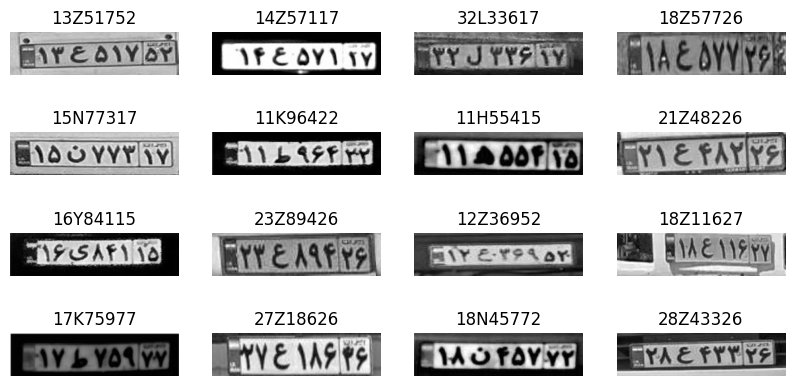

In [85]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch[0]
    labels = batch[1]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [142]:
# We have used two max pool with pool size and strides 2.
# Hence, downsampled feature maps are 16x smaller. The number of
# filters in the last layer is 128. Reshape accordingly before
# passing the output to the RNN part of the model
new_shape = (img_width // 16, (img_height // 16) * 256)
nclasses = len(char_to_num.get_vocabulary())

model=keras.models.Sequential([
                              layers.Input(shape=(img_width, img_height, 1)),#256
                              layers.Conv2D(32,(3, 3), activation="relu", padding="same"),
                              layers.MaxPooling2D((2, 2)),#128
                              layers.Conv2D(64,(3, 3), activation="relu", padding="same"),
                              layers.MaxPooling2D((2, 2)),#64
                              layers.Conv2D(128,(3, 3), activation="relu", padding="same"),
                              layers.MaxPooling2D((2, 2)),#32
                              layers.Conv2D(256,(3, 3), activation="relu", padding="same"),
                              layers.MaxPooling2D((2, 2)),#16
                              layers.Reshape(target_shape=new_shape),
                              layers.Dense(128, activation="relu"),
                              layers.Dropout(0.2),
                              layers.Conv1D(64, 3,activation="relu", padding="same"),
                              layers.MaxPool1D(2),
                              layers.Dropout(0.5),
                              layers.Dense(nclasses, activation="softmax")
                              ])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 256, 65, 32)       320       
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 128, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 128, 32, 64)       18496     
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 64, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_73 (Conv2D)          (None, 64, 16, 128)       73856     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 32, 8, 128)      

## Training

In [143]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [144]:
epochs = 100
early_stopping_patience = 30
reduce_lr_patience=10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=reduce_lr_patience)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/100
169/169 [==============================] - 6s 19ms/step - loss: 2.6207 - accuracy: 0.1724 - val_loss: 2.3344 - val_accuracy: 0.2204 - lr: 0.0010
Epoch 2/100
169/169 [==============================] - 3s 16ms/step - loss: 2.1622 - accuracy: 0.2818 - val_loss: 1.5741 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 3/100
169/169 [==============================] - 3s 16ms/step - loss: 1.3502 - accuracy: 0.5630 - val_loss: 0.8482 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 4/100
169/169 [==============================] - 3s 20ms/step - loss: 0.9489 - accuracy: 0.6864 - val_loss: 0.6243 - val_accuracy: 0.8037 - lr: 0.0010
Epoch 5/100
169/169 [==============================] - 3s 16ms/step - loss: 0.7557 - accuracy: 0.7581 - val_loss: 0.4837 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 6/100
169/169 [==============================] - 3s 17ms/step - loss: 0.6132 - accuracy: 0.8108 - val_loss: 0.3654 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 7/100
169/169 [==============================] - 3s 

In [146]:
model.evaluate(validation_dataset)

19/19 [==============================] - 0s 11ms/step - loss: 0.2657 - accuracy: 0.9608


[0.26570412516593933, 0.9608333110809326]

## Inference


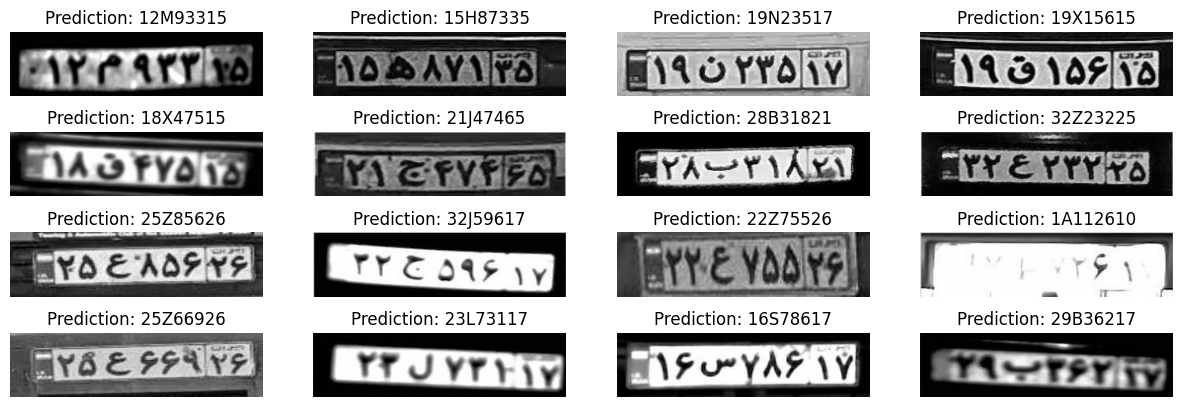

In [147]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch[0]
    batch_labels = batch[1]

    preds = model.predict(batch_images, verbose=0)
    preds = preds.argmax(axis=-1)

    pred_texts = []
    for p in preds:
        label = tf.strings.reduce_join(num_to_char(p)).numpy().decode("utf-8")
        pred_texts.append(label)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()